# Reinforcment Learning

Parts of this notebook has been reproduced from the [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) book.

The animation in this notebook only works with jupyter notebook and not with jupyter lab

In [30]:
import gym
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import torch
from torch import nn

In [24]:
%matplotlib notebook
%matplotlib notebook # Doing this twice is important...

In [3]:
def set_seed(seed):
    np.random.seed(seed)

In [4]:
# Functions for the fancy videos
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

## Quick Intro:

In reinforcment learning (RL) an agent makes observations of an enviroment and takes actions based on these observations. In return the agent receives rewards. The agent acts in the environment and learns by trial and error to maximise the reward.

Examples:
- **Walking robot**: real worl environment the, agent sees the world through sensors. Action is sending signals to activate motors. Rewards could be whenever it approaches a destination, negative rewards when it wastes time, falls down or goes in the wrong direction.
- **PacMan**: Environment is simulation of the game. Action = joystick direction. Obserbations are screen shots and rewards are game points.
- **Stock Market**: Agent can observe stock market prices and observe how much to buy or sell. Rewards are monetary gains and losses

In some cases there may not be a positive reward. For exmaple, an agent may move around a maze getting a negative reward at every timestep. So it is better to find the exit quickly.

### Policy Search

- Algorithm used by software agent to determine its actions is called its Policy
- Policy can be an algorithm and it does not have to deterministic. e.g. There could be a probability in choosing an action. This introduces randomness and is a stochastic policy

What parameters should be used for a policy? We can use policy search to find them:
- Brute force and search everything
- Use genetic algorithms. Generate 100 random policies, try them, kill 80 of the worst policies mane the 20 survivors produce 4 offspring each. Offspring is a copy of the parent + random variation. Continue iterating like this until you find a good policy.
- Policy Gradients. Evaluate the gradients of the rewards with regards to the policy parameters. Tweak these parameters by following the gradient toward higher rewards (gradient ascent)

### OpenAI Gym

One of the challenges in RL is that you need a working environment. Training is slow and hard in the real world so you generally need a simulated environment at least to bootstrap training. OpenAI gym provides a wide variety of simulated environments e.g. Atari games, board games, 2D and 3D physical simulations.

CartPole is a 2D simulation in which a cart is accelerated right or left in order to balance the pole. Lets play around with is example in OpenAI Gym

In [5]:
env = gym.make('CartPole-v0') # Create CartPole game environment
obs = env.reset() # Initialize the environment by reseting it

Each observation in the game is a 1D numpy array made up of 4 floats which represent:
- cart's horizontal position: 0.0 = centre
- velocity
- Angle of pole: 0.0 = vertical
- Angular velocity

In [6]:
obs

array([-0.03884452,  0.00342849, -0.03834506,  0.00415401])

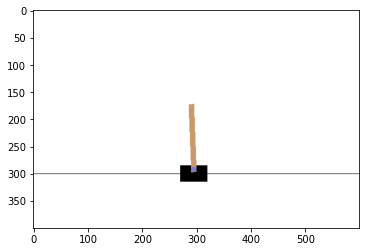

In [7]:
plt.imshow(env.render(mode='rgb_array')) # Render the image and plot. Will also annoyingly create a pop-up window

To view what actions are possible call `env.action_space`

In [8]:
env.action_space

Discrete(2)

This means that possible actions are 0 and 1. Which are accelerate left (0) or accelerate right (1). Other environments have many more actions and of different type e.g. continuous.

From the observation it looks like the pole in leaning slightly towards the left, let's take an action to move the cart left. The `env.step` method executes the action and returns 4 values:
- obs: the new observations.
- reward: In this environment you get a reward of 1 for every step. No matter what you do. So the goal is to keep running as long as possible.
- done: This will return `true` when the episode is over. Happens when the pole tilts too much. After which the environment must be reset.
- info: `Dict` that provides extra debug information. This should not be used for training!

In [9]:
obs, reward, done, info = env.step(0)

In [10]:
obs

array([-0.03877595, -0.19112316, -0.03826198,  0.28449628])

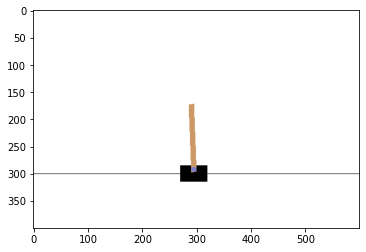

In [11]:
plt.imshow(env.render(mode='rgb_array'))

In [12]:
reward

1.0

In [13]:
done

False

In [14]:
info

{}

Let's create a simple policy that accelerates left when the pole is leaning left and move right when the pole is leaning right. We will run this for over 500 episodes

In [15]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [16]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(1000): # max 1000 steps, we eventually want to stop since there is no explicit end-game
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [17]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.694, 9.25269495876742, 24.0, 72.0)

With 500 attempts, this policy never manages to keep the pole upright for more than 68 steps!

In [76]:
frames = []
env = gym.make('CartPole-v0')
obs = env.reset()
for step in range(1000):
    img = env.render(mode='rgb_array')
    frames.append(img)
    # hard-coded policy
    action = basic_policy(obs)
    obs, reward, done, info = env.step(action)
    if done:
        break
env.close()

<IPython.core.display.Javascript object>


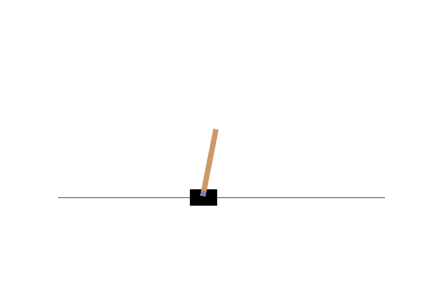

In [77]:
video = plot_animation(frames)
plt.show()

In [75]:
len(frames)

32

## Neural Nework Policies

- Take an observation as an input
- Output is an action
- Will estimate the probability for each action, then select the action randomly according to the estimated probabilities

Why not just pick the highest probable action?
This lets the agent find the right balance between exploring new actions and exploiting actions that are known to work well

In this case past actions can be ignored, since each observation contains the environments full state. If there was a hidden state, you may need to consider past actions and observations.

Below is a simple neural network model which takes the 4 cartpole inputs passes it through an activation to another linear layer with a single output and then finally a sigmoid to calculate the probability. 
$$
Move\ Left\ Probability = Model(x) \\
Move\ Right\ Probability = 1 - Model(x)
$$

In [34]:
model = nn.Sequential(
    nn.Linear(4, 4),
    nn.ELU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

Example Model call:

In [37]:
model(torch.tensor([1,2,3,4],dtype=torch.float))

tensor([0.1579], grad_fn=<SigmoidBackward>)

Prob left = ~15% <br>
Prob right = ~85%

Next we create a tensor of proabilities:

In [39]:
output = model(torch.tensor([1,2,3,4], dtype=torch.float))

In [68]:
probabilities = torch.tensor([output, 1-output], dtype=torch.float)

In [69]:
probabilities

tensor([0.1579, 0.8421])

Pass it through a multinomial function to pick an action based on the probabilities. Note, the function returns the index of the selected probaility. Hence, why left is index 0 becuase action 0 is to move left in the environment.

In [70]:
torch.multinomial(probabilities, 1)

tensor([1])

Picked action 1.

Now that we have a neural network policy that will take observations and output actions, how do we train it?

## Evaluating Actions: Credit Assignment Problem

If we knew the best action at each step we would simply train the neural network in a supervised manner via minimisation of the cross-entropy. In RL the only guidance the agent gets is through rewards and rewards are typically sparse and delayed. For example, if the agent balances the pole in the game above for 100 actions how does it know which steps are good and which are bad? All we know is the pole fell at the last action, but the last action is not entirely responsible. This is called the **Credit Assignment** problem. When an agent gets a reward it is hard to know which actions should get credited (or blamed) for it.

One common strategy is to evaluate an action based on the sum of all rewards that come after it. This is usually done by applying a discount rate $r$ at each step.

e.g. If an agent decided to go right three times in the cart pole game with a discount rate of 0.8 and has the following rewards at each step:
- step 1: 10
- step 2: 0
- step 3: -50

The final reward score would be -22 becuase we start from step 3 and work backwards:

- step 3: -50 * 0.8 = -40
- step 2: (0 + -40) * 0.8 = -32
- step 1: 10 + -32 = -22 

If the discount rate is close to 0 then future rewards won't count for much compared to immediate rewards. If the discount rate is close to 1, then future rewards will almost count as much as immediate rewards. Typical values for discount rates are 0.95 and 0.99. If a discount rate is set to 0.95 then 13 steps into the future count roughly for half as much as immediate rewards $0.95^{13} \approx 0.5$. If the discount rate is 0.99, rewards 69 steps into the future count for half as much $0.99^{69} \approx 0.5$

In the cartpole environment actions have fairly short-term effects so choosing a discount rate of 0.95 seems reasonable.

A good action may be followed by bad actions resulting in the good action getting a low score. If the game is played enought times on average good actions will get a better score than the bad ones. To get a fairly reliable action scores the game must be run over many episodes and normalise all the action scores (subtracting the mean and dividing by the standard deviation). After that we can assume actions with positive scores are good and negative are bad. We now have a way of evaluating each action, we can no train a policy gradient!